In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sys.path.append("..")  # if simulator.ipynb is in /notebooks/

from simulation.core import System
from simulation.controller import TrafficController
from simulation.data_logger import DataLogger
from simulation.core import Road, Obstacle
from simulation.spawners import timed_spawner, density_random_lane_spawner
from helper import plot_graphs, get_average_velocity, plot_density_by_space, calculate_shockwave_speed_circular_road


In [ ]:
dt = 0.1
sim_time = 1800

road_length = 2100
max_speed = 30

num_lanes = 1

# density = 0.08

system = System(dt=dt, final_time=sim_time)

start_pos = (0, 300)
end_pos = (road_length, 300)
road = Road(num_lanes, max_speed, start_pos, end_pos)

system = System(dt=dt, final_time=sim_time)

start_pos = (0, 300)
end_pos = (road_length, 300)
road = Road(num_lanes, max_speed, start_pos, end_pos)

system.add_road(road)
logger = DataLogger(tag="mix_driver_density")
controller = TrafficController(system)

logger.enable_sensor_logger(sensor_location=500, aggregation_window=30)
controller.add_exit_gate(1600)

controller.add_spawn_rule(density_random_lane_spawner(2250, 0, 10000, "calibration", 15))




In [26]:
for _ in range(int(sim_time/dt)):
    controller.control(system.dt)
    system.update(logger=logger)

new_df = logger.to_dataframe()
# density_df = logger.to_density_dataframe()
# flow_df = logger.to_flow_dataframe()
speed_average = logger.to_sensor_dataframe()

The current time now is: 50.00000000000044
The current time now is: 100.09999999999859
The current time now is: 150.09999999999576
The current time now is: 200.09999999999292
The current time now is: 250.09999999999008
The current time now is: 300.09999999999974
The current time now is: 350.0000000000111
The current time now is: 400.00000000002245
The current time now is: 450.0000000000338
The current time now is: 500.0000000000452
The current time now is: 550.0000000000565
The current time now is: 600.0000000000679
The current time now is: 650.0000000000792
The current time now is: 700.0000000000906
The current time now is: 750.000000000102
The current time now is: 800.0000000001133
The current time now is: 850.0000000001247
The current time now is: 900.0000000001361
The current time now is: 950.0000000001475
The current time now is: 1000.0000000001588
The current time now is: 1050.0000000001405
The current time now is: 1100.000000000095
The current time now is: 1150.0000000000496
The

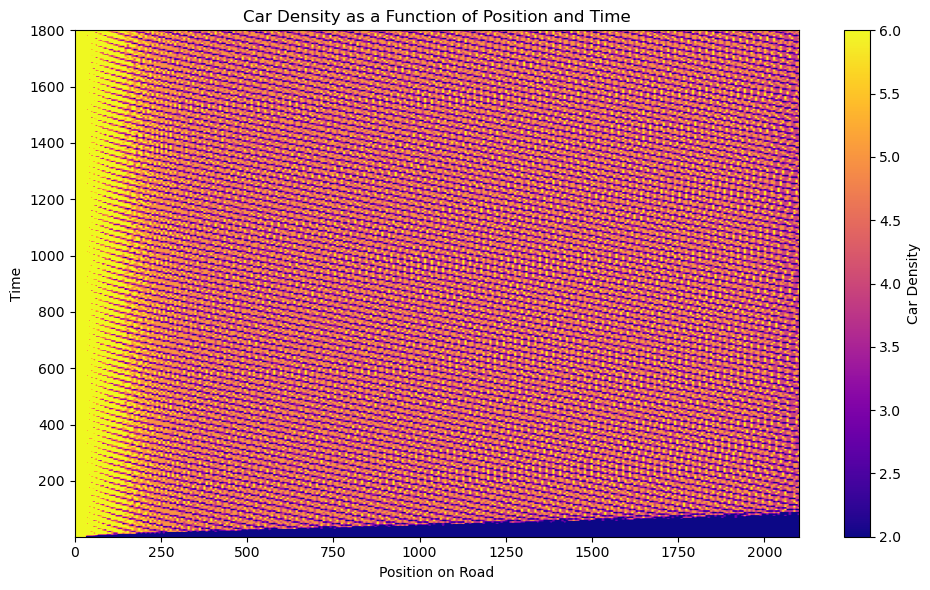

In [27]:
plot_density_by_space(new_df, road_length = 2100)



In [29]:
dt = 0.1
sim_time = 1500

road_length = 1000
max_speed = 100

num_lanes = 4

def test_loop(densities, should_print = False):

    dataframes = []
    density_dfs = []
    flow_dfs = []

    for density in densities:

        print("Starting simulation for density: ", density)

        system = System(dt=dt, final_time=sim_time)

        start_pos = (0, 300)
        end_pos = (road_length, 300)
        road = Road(num_lanes, max_speed, start_pos, end_pos)

        system.add_road(road)
        logger = DataLogger(tag="random_driver_density")
        controller = TrafficController(system, logger=logger)

        system.equal_distance_car_creator(int(road_length*density), road_index = 0, lane_index = 0, speed = 0, driver_type="random")
        system.equal_distance_car_creator(int(road_length*density), road_index = 0, lane_index = 1, speed = 0, driver_type="random")
        system.equal_distance_car_creator(int(road_length*density), road_index = 0, lane_index = 2, speed = 0, driver_type="random")
        system.equal_distance_car_creator(int(road_length*density), road_index = 0, lane_index = 3, speed = 0, driver_type="random")
        

        road.set_next_road(road)


        for _ in range(int(sim_time / dt)):
            end = controller.control(dt, should_print=should_print)
            system.update(logger)
    
            if end:
                break

        df = logger.to_dataframe()
        density_df = logger.to_density_dataframe()
        flow_df = logger.to_flow_dataframe()
        dataframes.append(df)
        density_dfs.append(density_df)
        flow_dfs.append(flow_df)

        print("Logging to dataframe!")


    return dataframes, density_dfs, flow_dfs

In [ ]:
densities = np.linspace(0.06, 0.08, 30)

dataframes, density_dfs, flow_dfs = test_loop(densities)


In [3]:
n=29

calculate_shockwave_speed_circular_road(density_dfs[n], flow_dfs[n])
plot_density_by_space(dataframes[n], road_length = road_length)




NameError: name 'density_dfs' is not defined

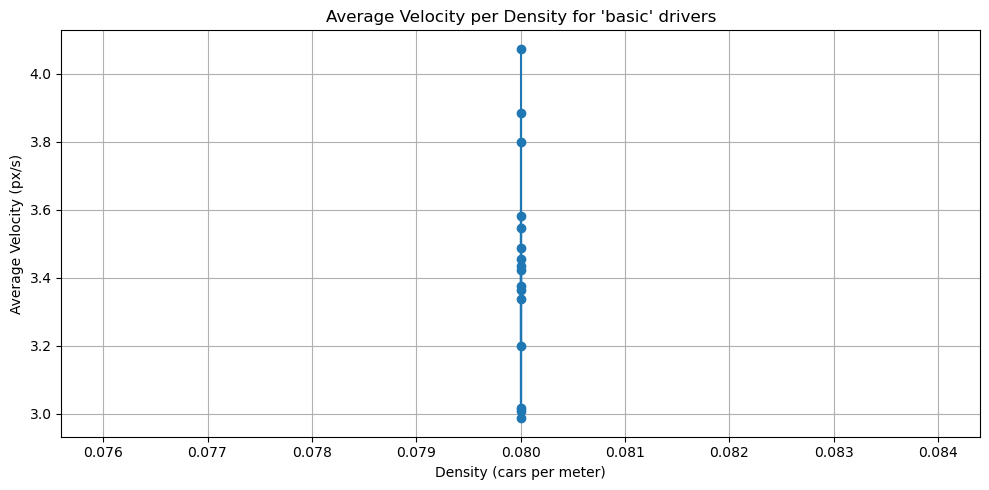

In [125]:
avg_velocities = [get_average_velocity(df, 0.15, 1) for df in dataframes]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(densities, avg_velocities, marker='o')
plt.xlabel("Density (cars per meter)")
plt.ylabel("Average Velocity (px/s)")
plt.title(f"Average Velocity per Density for 'basic' drivers")
plt.grid(True)
plt.tight_layout()
plt.show()

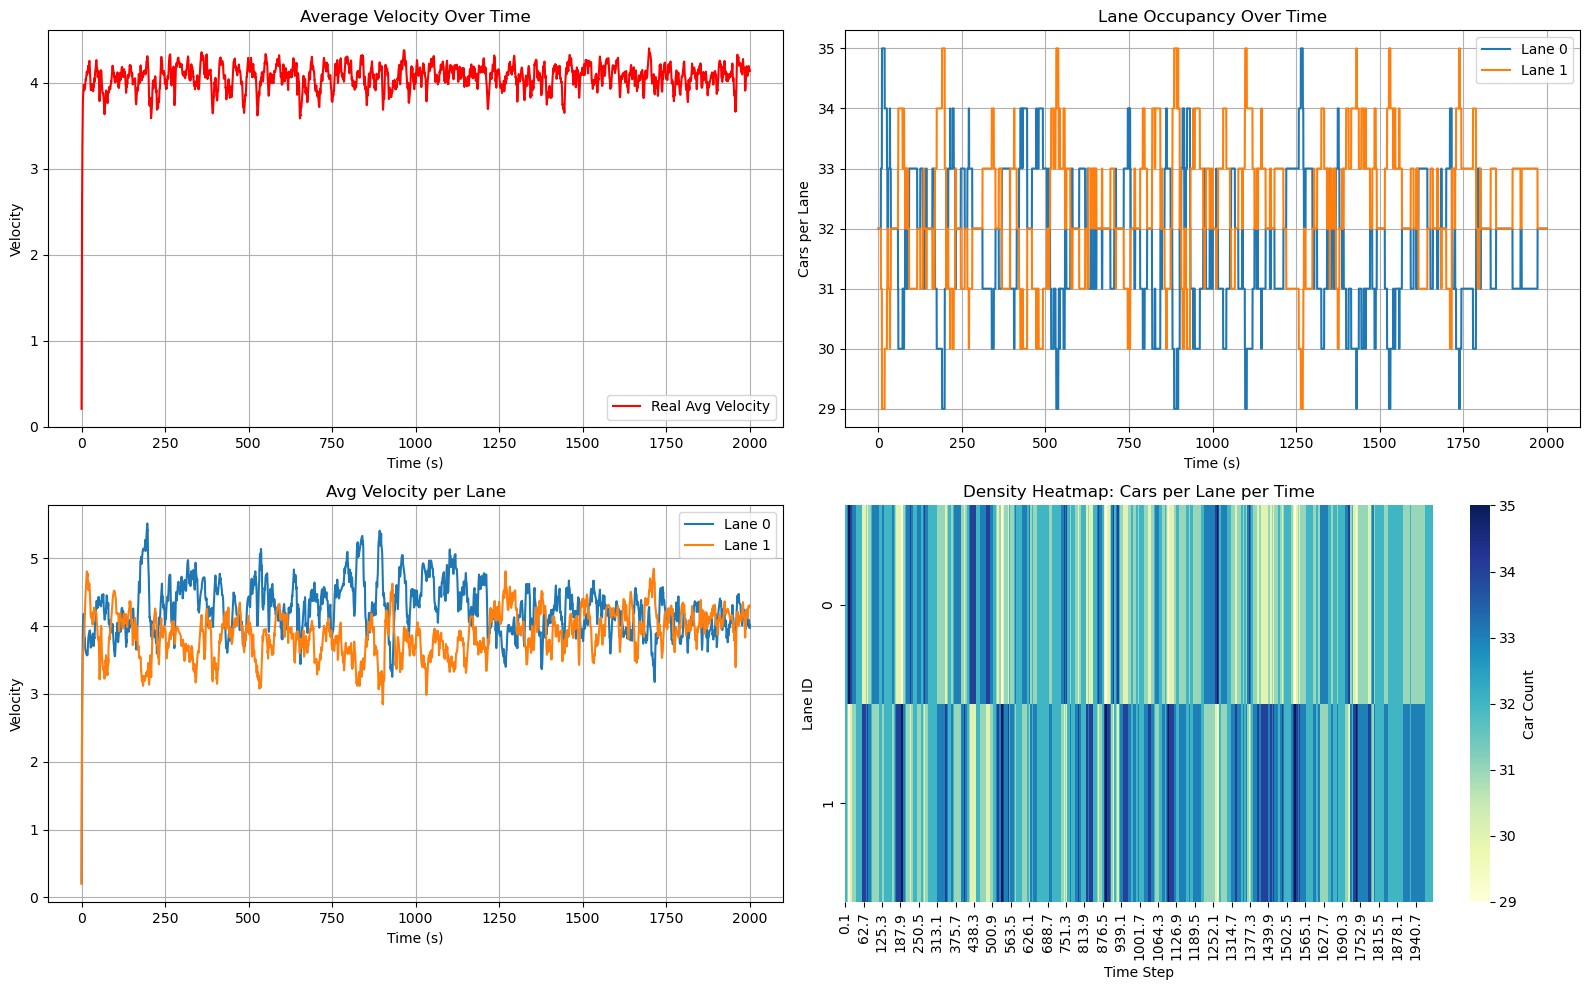

In [126]:
plot_graphs(dataframes[0])


64.0


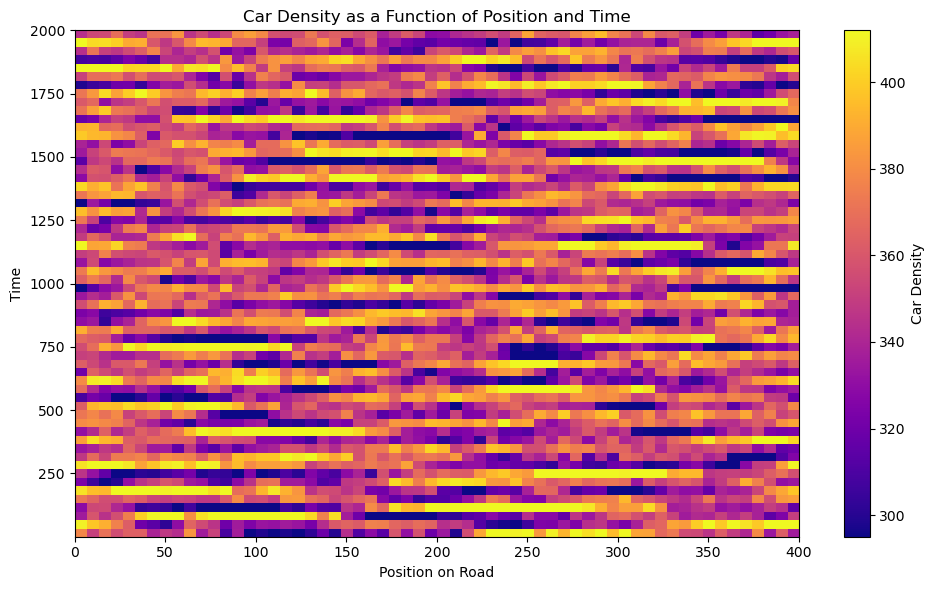

In [127]:
n = 5

print(densities[n]*road_length*num_lanes)
plot_density_by_space(dataframes[n], road_length = 400)

In [ ]:
# Save the data for later use
with pd.HDFStore("logs/Test_1.h5") as store:
    for i, df in enumerate(dataframes):
        store[f"log_{i}"] = df
        store.put("metadata", pd.Series({"tag": "Test_1", "dt": 0.1, "crash_step": 2500}))


C:\Users\TLP-001\AppData\Local\Temp\ipykernel_45072\1180309809.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  store.put("metadata", pd.Series({"tag": "Test_1", "dt": 0.1, "crash_step": 2500}))


In [ ]:
with pd.HDFStore("logs/Test_1.h5") as store:
    dataframes = [store[key] for key in store.keys()]
    print("Dataframes loaded into 'dataframes'")

Dataframe loaded into 'dataframes'


In [4]:
plot_graphs(dataframes[0])

NameError: name 'dataframes' is not defined